In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [32]:
base_image_path = "ucsd2.jpg"
style_reference_image_path = "gogh.jpg"

total_variation_weight = 1.0
style_weight = 100.0
content_weight = 0.025 

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [33]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img) * 1.0
    img = np.expand_dims(img, axis=0)
#     img = vgg16.preprocess_input(img) 
    return img


def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x


base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, 3, img_nrows, img_ncols))

In [34]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
#     print sLoss.eval()
    return sLoss

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [66]:
def get_loss2(y_true, y_pred):
    sty = (style_reference_image)/256.0
    combo =  y_pred#vgg16.preprocess_input (y_pred * 256)
    base = (base_image)/256.0

    input_tensor = K.concatenate([base, sty, combo], axis=0)

    model = vgg16.VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
    print('Model loaded.')

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = content_weight * content_loss(base_image_features, combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
    
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
   
    loss += total_variation_weight * total_variation_loss(combo)
    return loss 

In [67]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))

# Layer 1
x1 = Dense(5, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(64*56*56, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((64, 56, 56))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) 
x = Convolution2D(16, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 4
# x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# # Layer 5
# x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
# x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) 
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

In [68]:
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.reshape(inp, (3, -1))
inpY = 1.0 * np.reshape(inp, (1, 3, 224, 224)) 


jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

inpY = inpY/256.0

150528


In [69]:
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
generative_model.compile(loss = get_loss2, optimizer = adam_op)

Model loaded.


Epoch 1/10
1/1 [==============================] - 0s - loss: 23769.6113
Epoch 2/10
1/1 [==============================] - 0s - loss: 23523.9473
Epoch 3/10
1/1 [==============================] - 0s - loss: 23284.8320
Epoch 4/10
1/1 [==============================] - 0s - loss: 23051.0938
Epoch 5/10
1/1 [==============================] - 0s - loss: 22821.8652
Epoch 6/10
1/1 [==============================] - 0s - loss: 22596.9902
Epoch 7/10
1/1 [==============================] - 0s - loss: 22376.6074
Epoch 8/10
1/1 [==============================] - 0s - loss: 22161.5488
Epoch 9/10
1/1 [==============================] - 0s - loss: 21952.4082
Epoch 10/10
1/1 [==============================] - 0s - loss: 21749.2793
(3, 224, 224)


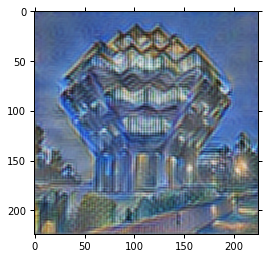

Epoch 1/10
1/1 [==============================] - 0s - loss: 21550.9102
Epoch 2/10
1/1 [==============================] - 0s - loss: 21358.2969
Epoch 3/10
1/1 [==============================] - 0s - loss: 21171.6777
Epoch 4/10
1/1 [==============================] - 0s - loss: 20990.4688
Epoch 5/10
1/1 [==============================] - 0s - loss: 20814.0195
Epoch 6/10
1/1 [==============================] - 0s - loss: 20641.4453
Epoch 7/10
1/1 [==============================] - 0s - loss: 20472.3672
Epoch 8/10
1/1 [==============================] - 0s - loss: 20306.9355
Epoch 9/10
1/1 [==============================] - 0s - loss: 20145.1211
Epoch 10/10
1/1 [==============================] - 0s - loss: 19986.8828
(3, 224, 224)


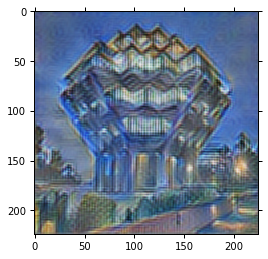

Epoch 1/10
1/1 [==============================] - 0s - loss: 19832.1992
Epoch 2/10
1/1 [==============================] - 0s - loss: 19680.6445
Epoch 3/10
1/1 [==============================] - 0s - loss: 19532.4902
Epoch 4/10
1/1 [==============================] - 0s - loss: 19388.3203
Epoch 5/10
1/1 [==============================] - 0s - loss: 19247.0566
Epoch 6/10
1/1 [==============================] - 0s - loss: 19109.2207
Epoch 7/10
1/1 [==============================] - 0s - loss: 18974.9473
Epoch 8/10
1/1 [==============================] - 0s - loss: 18843.3535
Epoch 9/10
1/1 [==============================] - 0s - loss: 18714.5137
Epoch 10/10
1/1 [==============================] - 0s - loss: 18588.5020
(3, 224, 224)


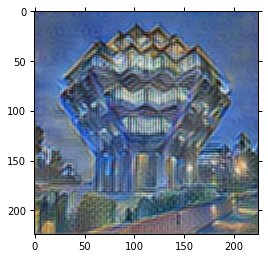

Epoch 1/10
1/1 [==============================] - 0s - loss: 18464.6191
Epoch 2/10
1/1 [==============================] - 0s - loss: 18342.8789
Epoch 3/10
1/1 [==============================] - 0s - loss: 18224.6211
Epoch 4/10
1/1 [==============================] - 0s - loss: 18108.7383
Epoch 5/10
1/1 [==============================] - 0s - loss: 17994.4629
Epoch 6/10
1/1 [==============================] - 0s - loss: 17882.2480
Epoch 7/10
1/1 [==============================] - 0s - loss: 17772.3477
Epoch 8/10
1/1 [==============================] - 0s - loss: 17664.5098
Epoch 9/10
1/1 [==============================] - 0s - loss: 17558.4316
Epoch 10/10
1/1 [==============================] - 0s - loss: 17454.3457
(3, 224, 224)


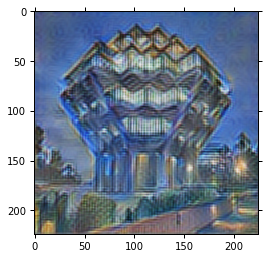

Epoch 1/10
1/1 [==============================] - 0s - loss: 17352.3457
Epoch 2/10
1/1 [==============================] - 0s - loss: 17252.9531
Epoch 3/10
1/1 [==============================] - 0s - loss: 17155.8633
Epoch 4/10
1/1 [==============================] - 0s - loss: 17060.3398
Epoch 5/10
1/1 [==============================] - 0s - loss: 16966.7051
Epoch 6/10
1/1 [==============================] - 0s - loss: 16874.2383
Epoch 7/10
1/1 [==============================] - 0s - loss: 16782.7148
Epoch 8/10
1/1 [==============================] - 0s - loss: 16692.8320
Epoch 9/10
1/1 [==============================] - 0s - loss: 16604.7207
Epoch 10/10
1/1 [==============================] - 0s - loss: 16518.4512
(3, 224, 224)


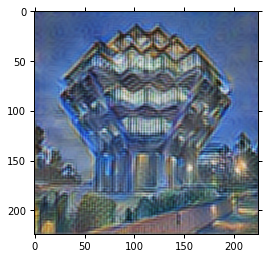

Epoch 1/10
1/1 [==============================] - 0s - loss: 16433.9434
Epoch 2/10
1/1 [==============================] - 0s - loss: 16351.1133
Epoch 3/10
1/1 [==============================] - 0s - loss: 16270.0283
Epoch 4/10
1/1 [==============================] - 0s - loss: 16190.9170
Epoch 5/10
1/1 [==============================] - 0s - loss: 16113.4326
Epoch 6/10
1/1 [==============================] - 0s - loss: 16037.3145
Epoch 7/10
1/1 [==============================] - 0s - loss: 15962.4648
Epoch 8/10
1/1 [==============================] - 0s - loss: 15888.7393
Epoch 9/10
1/1 [==============================] - 0s - loss: 15816.0879
Epoch 10/10
1/1 [==============================] - 0s - loss: 15744.3730
(3, 224, 224)


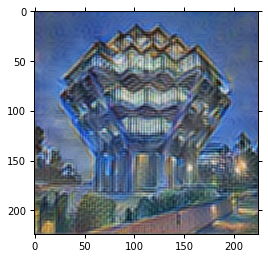

Epoch 1/10
1/1 [==============================] - 0s - loss: 15673.6992
Epoch 2/10
1/1 [==============================] - 0s - loss: 15604.0967
Epoch 3/10
1/1 [==============================] - 0s - loss: 15535.4463
Epoch 4/10
1/1 [==============================] - 0s - loss: 15468.3740
Epoch 5/10
1/1 [==============================] - 0s - loss: 15402.4990
Epoch 6/10
1/1 [==============================] - 0s - loss: 15337.7510
Epoch 7/10
1/1 [==============================] - 0s - loss: 15273.7490
Epoch 8/10
1/1 [==============================] - 0s - loss: 15210.4072
Epoch 9/10
1/1 [==============================] - 0s - loss: 15148.0938
Epoch 10/10
1/1 [==============================] - 0s - loss: 15086.9131
(3, 224, 224)


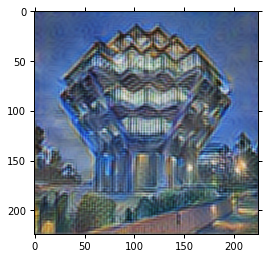

Epoch 1/10
1/1 [==============================] - 0s - loss: 15027.0957
Epoch 2/10
1/1 [==============================] - 0s - loss: 14968.3047
Epoch 3/10
1/1 [==============================] - 0s - loss: 14910.4004
Epoch 4/10
1/1 [==============================] - 0s - loss: 14853.6309
Epoch 5/10
1/1 [==============================] - 0s - loss: 14797.8555
Epoch 6/10
1/1 [==============================] - 0s - loss: 14743.0801
Epoch 7/10
1/1 [==============================] - 0s - loss: 14689.1055
Epoch 8/10
1/1 [==============================] - 0s - loss: 14636.0293
Epoch 9/10
1/1 [==============================] - 0s - loss: 14583.7588
Epoch 10/10
1/1 [==============================] - 0s - loss: 14531.8564
(3, 224, 224)


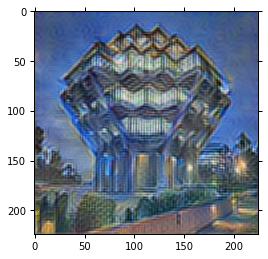

Epoch 1/10
1/1 [==============================] - 0s - loss: 14480.4141
Epoch 2/10
1/1 [==============================] - 0s - loss: 14429.8828
Epoch 3/10
1/1 [==============================] - 0s - loss: 14379.9434
Epoch 4/10
1/1 [==============================] - 0s - loss: 14330.7979
Epoch 5/10
1/1 [==============================] - 0s - loss: 14282.3916
Epoch 6/10
1/1 [==============================] - 0s - loss: 14234.6592
Epoch 7/10
1/1 [==============================] - 0s - loss: 14187.4316
Epoch 8/10
1/1 [==============================] - 0s - loss: 14140.8857
Epoch 9/10
1/1 [==============================] - 0s - loss: 14094.7295
Epoch 10/10
1/1 [==============================] - 0s - loss: 14049.1104
(3, 224, 224)


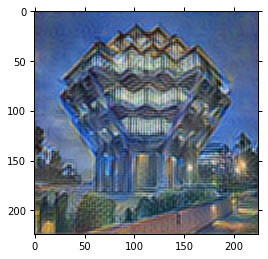

Epoch 1/10
1/1 [==============================] - 0s - loss: 14003.9658
Epoch 2/10
1/1 [==============================] - 0s - loss: 13959.4102
Epoch 3/10
1/1 [==============================] - 0s - loss: 13915.2314
Epoch 4/10
1/1 [==============================] - 0s - loss: 13871.4570
Epoch 5/10
1/1 [==============================] - 0s - loss: 13828.3906
Epoch 6/10
1/1 [==============================] - 0s - loss: 13785.7305
Epoch 7/10
1/1 [==============================] - 0s - loss: 13743.5439
Epoch 8/10
1/1 [==============================] - 0s - loss: 13701.7812
Epoch 9/10
1/1 [==============================] - 0s - loss: 13660.4600
Epoch 10/10
1/1 [==============================] - 0s - loss: 13619.5479
(3, 224, 224)


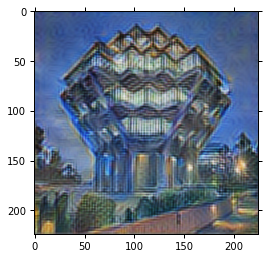

In [71]:
for i in range(10):
    generative_model.fit(trainX3, inpY, nb_epoch = 10)
    img = generative_model.predict(trainX3)
    img = img[0]
    print img.shape
    img = img.swapaxes(0, 2).swapaxes(0, 1)
    plt.imshow(img)
    plt.show()

In [73]:
jpgfile = Image.open("orig.jpg")
inp = np.array(jpgfile.getdata())
trainX = np.reshape(inp, (1, 3, 224, 224))
trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
trainX3 = trainX2/256.0
print np.product(trainX.shape)
trainX3 = np.random.rand(1, 150528)

150528


(224, 224, 3)


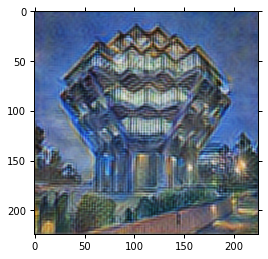

In [86]:
img = generative_model.predict( np.random.rand(1, 150528))
img = img[0]
imgB = img.swapaxes(0, 2).swapaxes(0, 1)
print imgB.shape
plt.imshow(imgB)
# plt.show()

In [82]:
def get_train_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    trainX = np.reshape(inp, (1, 3, 224, 224))
    trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
    trainX3 = trainX/256.0
    return trainX3